In [1]:
#Fake News Detection 
#Fitting, Training a Model + Testing 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Import processed datasets
processedData_en = pd.read_csv("Processed Text-Dataset/Processed_EN_Data.csv")
processedData_spn = pd.read_csv("Processed Text-Dataset/Processed_Spn_Data.csv")

In [3]:
#Split datasets into training and testing portion 
def splitInto_Train_TestData(dataset): 
    numRows = len(dataset)
    trainIndex = round(numRows*0.8)
    trainData = dataset.iloc[:trainIndex]
    testData = dataset.iloc[trainIndex:]
    return [trainData, testData]

In [4]:
#English Train and Test Portion of Dataset
split_EnData = splitInto_Train_TestData(processedData_en) 
enTrain = split_EnData[0]
enTest = split_EnData[1]

#Spanish Train and Test Portion of Dataset
split_SpnData = splitInto_Train_TestData(processedData_spn)
spnTrain = split_SpnData[0]
spnTest = split_SpnData[1]

In [6]:
#Feature Extraction - Vectorize strings into numbers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

count_vectorizer = CountVectorizer(lowercase=False)

def vectorizeTrainData(df): 
    textCol = df['Text']
    #CountVectorize() does not like nan values using fit_transform()...so convert nan to empty string
    textList = list(textCol.replace(np.nan,'',regex=True))
    x = count_vectorizer.fit_transform(textList).toarray()
    #Convert Category label into numbers (0,1) for Fake and Real respectively
    y = df['Category'].values
    y = LabelEncoder().fit_transform(y)
    return [x, y]

def vectorizeTestData(df):     
    textCol = df['Text']
    #CountVectorize() does not like nan values using fit_transform()...so convert nan to empty string
    textList = list(textCol.replace(np.nan,'',regex=True))
    x = count_vectorizer.transform(textList).toarray()
    #Convert Category label into numbers (0,1) for Fake and Real respectively
    y = df['Category'].values
    y = LabelEncoder().fit_transform(y)
    return [x, y]

#Import models 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
 
#Metrics to evaluate Model - Import
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [7]:
#Vectorize English Training and Testing Datasets
enTrainVect = vectorizeTrainData(enTrain)
enTestVect = vectorizeTestData(enTest)

#Vectorize Spanish Training and Testing Datasets
spnTrainVect = vectorizeTrainData(spnTrain)
spnTestVect = vectorizeTestData(spnTest)

In [8]:
#Train model and test it
def modeling(model, trainVect, testVect): 
    model.fit(trainVect[0], trainVect[1])
    y_pred = model.predict(testVect[0]) 
    #Calculate accuracy btwn predicted values by model and actual values from Dataset
    acc = accuracy_score(testVect[1], y_pred)
    #Calculate probability for positive outcome 
    y_pos = model.predict_proba(testVect[0])[:, 1]
    #Return necessary information (values in dict) needed for keys --> makes it easier to access 
    return {'model': model, 'confusionMatrix' : [testVect[1], y_pred], 'accuracy': acc, 'PrecisionRecall': [testVect[1], y_pos]}

#Function to pass correct vectorized data to model() and display accuracy and confusion matrix
def makeModel(model, language): 
    if language == 'en':
        trainVect = enTrainVect
        testVect = enTestVect
        lang = 'English'
    elif language == 'spn': 
        trainVect = spnTrainVect
        testVect = spnTestVect
        lang = 'Spanish'
    else: 
         raise ValueError("Invalid arguments")
       
    modelDict = modeling(model, trainVect, testVect)
    acc = modelDict['accuracy']
    print("Model trained in " + lang + " and using " + str(model) + " model has {:.2%} accuracy" .format(acc))
    
    #Make confusion matrix for model
    yVectTest = modelDict['confusionMatrix'][0]
    y_pred = modelDict['confusionMatrix'][1]
    cf_matrix = confusion_matrix(yVectTest, y_pred)
    #Labels for each quadrant & value
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
    title = "Confusion Matrix for " + str(model)  + "in " + lang + "\n\n"
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    #Labels must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
    return modelDict

from  matplotlib.ticker import PercentFormatter
#bar chart for accuracy 
def barChart(modelList, title): 
    labelList =[]
    valList = []
    
    for model in modelList:
        modelStr = str(model['model'])
        labelList.append(modelStr)
        accuracy =model['accuracy']*100
        valList.append(accuracy)
        
    dataDict = {'label' : labelList, 'value' : valList} 
    plt.figure(figsize=(5,5))
    ax = sns.barplot(x='label', y='value', data=dataDict)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('\nModels', fontsize = 15)
    ax.set_ylabel('Accuracy %', fontsize = 15)
    ax.yaxis.set_major_formatter(PercentFormatter())
    for c in ax.containers:
        ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)
    
from sklearn.metrics import precision_recall_curve
def precisionRecallChart(modelList, title):
    precisionList =[]
    recallList = []
    labelList =[]
    
    for model in modelList:
        modelStr = str(model['model'])
        y_test = model['PrecisionRecall'][0]
        y_score = model['PrecisionRecall'][1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
         #Set up data for long format 
        for i in range(0, len(precision)):
            labelList.append(modelStr)
            precisionList.append(precision[i])
            recallList.append(recall[i])
        
    dataDf = pd.DataFrame((zip(labelList, recallList, precisionList)),columns =['Model', 'Recall', 'Precision'])
    ax = sns.lineplot(x="Recall", y="Precision", data = dataDf, hue="Model")
    ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1))
    ax.set_title(title, fontsize = 15)

In [9]:
#Models used in this order: 
models = [GaussianNB(), LogisticRegression(max_iter=300), SGDClassifier(loss="modified_huber"), RandomForestClassifier(), DecisionTreeClassifier()]

Model trained in English and using GaussianNB() model has 67.06% accuracy


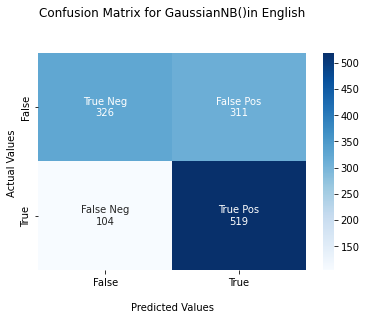

Model trained in English and using LogisticRegression(max_iter=300) model has 88.41% accuracy


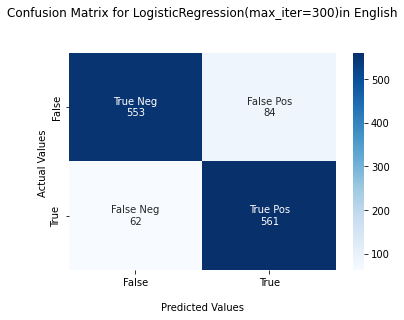

Model trained in English and using SGDClassifier(loss='modified_huber') model has 89.21% accuracy


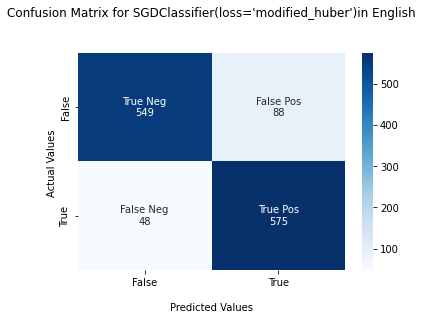

Model trained in English and using RandomForestClassifier() model has 88.10% accuracy


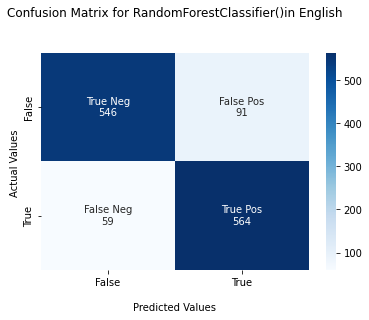

Model trained in English and using DecisionTreeClassifier() model has 78.49% accuracy


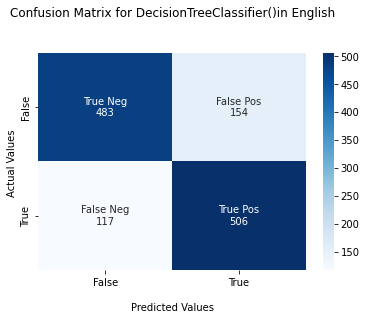

In [10]:
#English Models 
engModelList = []
for model in models: 
    enModel = makeModel(model, 'en')
    engModelList.append(enModel)

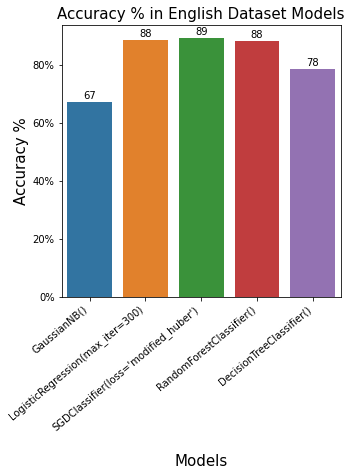

In [11]:
#Accuracy bar graph 
barChart(engModelList, 'Accuracy % in English Dataset Models')

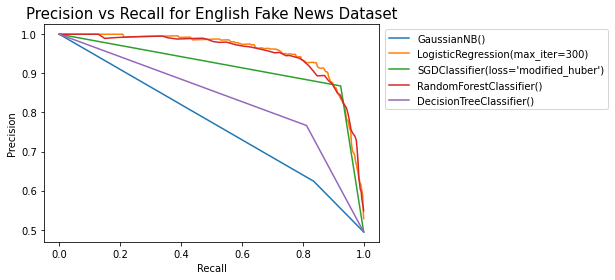

In [12]:
precisionRecallChart(engModelList, 'Precision vs Recall for English Fake News Dataset')

Model trained in Spanish and using GaussianNB() model has 59.26% accuracy


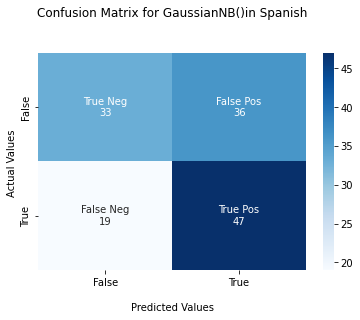

Model trained in Spanish and using LogisticRegression(max_iter=300) model has 75.56% accuracy


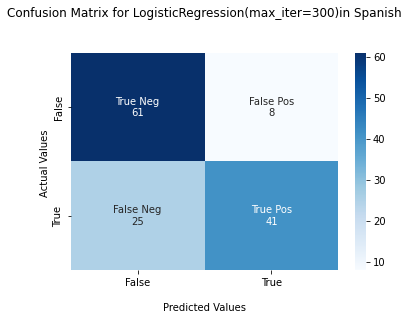

Model trained in Spanish and using SGDClassifier(loss='modified_huber') model has 74.07% accuracy


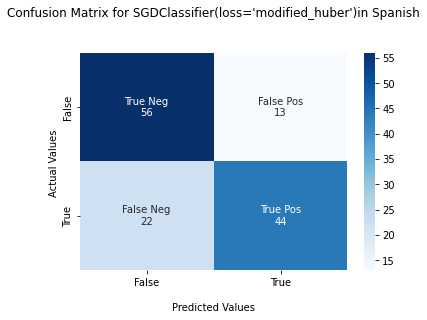

Model trained in Spanish and using RandomForestClassifier() model has 73.33% accuracy


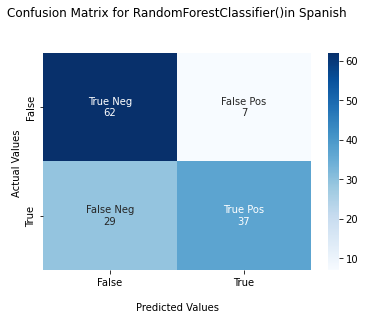

Model trained in Spanish and using DecisionTreeClassifier() model has 68.15% accuracy


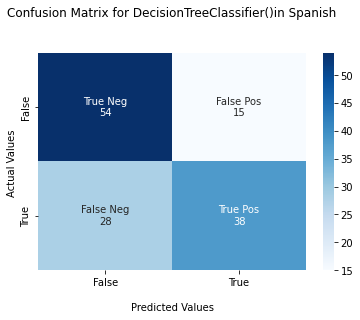

In [13]:
#Spaniish Models 
spnModelList = []
for model in models: 
    spnModel = makeModel(model, 'spn')
    spnModelList.append(spnModel)

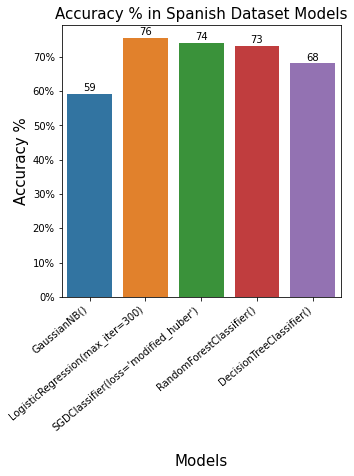

In [14]:
barChart(spnModelList, 'Accuracy % in Spanish Dataset Models')

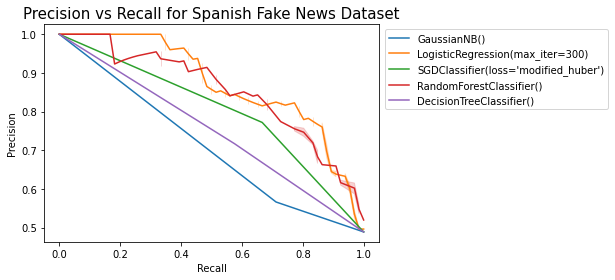

In [15]:
precisionRecallChart(spnModelList, 'Precision vs Recall for Spanish Fake News Dataset')